In [48]:
import os
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data Download

In [2]:
# 결과물을 저장할 폴더를 만듭니다.
path = ['data', 'model', 'result', 'img']
for i in path:
    if not os.path.exists(i):
        os.mkdir(i)

In [12]:
if not os.path.exists('data/train.csv'):
    !kaggle competitions download -c playground-series-s5e5
    !unzip playground-series-s5e5.zip -d data
    !rm playground-series-s5e5.zip
    !kaggle datasets download ruchikakumbhar/calories-burnt-prediction
    !unzip calories-burnt-prediction.zip -d data
    !rm calories-burnt-prediction.zip

In [13]:
import sgml, sgpp, dproc, sgutil

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

sc = sgutil.SGCache('img', 'result', 'model')

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, ShuffleSplit

from scipy.stats import kruskal

# Data processing

**Task**

- Train / Test / Org 데이터를 불러오는 루틴 디자인합니다.
- Calories를 Log 변환하고 이 변수를 Calories_Log로 합니다.

In [15]:
p = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'id')
)
df_train = p.fit_transform(['data/train.csv']).assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log
id,,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280
1,female,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348
2,female,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197
3,male,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760
4,female,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433


- 테스트 데이터를 불러 옵니다.

In [16]:
df_test = p.transform(['data/test.csv'])
df_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.799999
750001,male,26,200.0,97.0,20.0,101.0,40.500000
750002,female,29,188.0,85.0,16.0,102.0,40.400002
750003,female,39,172.0,73.0,20.0,107.0,40.599998
750004,female,30,173.0,67.0,16.0,94.0,40.500000


- 원본 데이터를 불러 옵니다.

In [17]:
p_org = make_pipeline(
    sgpp.PolarsProcessor(),
    sgpp.PandasConverter(index_col = 'User_ID')
)
df_org = p_org.fit_transform(['data/calories.csv']).reset_index(drop=True).pipe(
    lambda x: x.set_index(-(x.index + 1))
)
df_org.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
-1,male,68,190.0,94.0,29.0,105.0,40.799999,231.0
-2,female,20,166.0,60.0,14.0,94.0,40.299999,66.0
-3,male,69,179.0,79.0,5.0,88.0,38.700001,26.0
-4,female,34,179.0,71.0,13.0,100.0,40.500000,71.0
-5,female,27,154.0,58.0,10.0,81.0,39.799999,35.0


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Sex           750000 non-null  category
 1   Age           750000 non-null  int8    
 2   Height        750000 non-null  float32 
 3   Weight        750000 non-null  float32 
 4   Duration      750000 non-null  float32 
 5   Heart_Rate    750000 non-null  float32 
 6   Body_Temp     750000 non-null  float32 
 7   Calories      750000 non-null  float32 
 8   Calories_Log  750000 non-null  float32 
dtypes: category(1), float32(7), int8(1)
memory usage: 24.3 MB


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Sex         250000 non-null  category
 1   Age         250000 non-null  int8    
 2   Height      250000 non-null  float32 
 3   Weight      250000 non-null  float32 
 4   Duration    250000 non-null  float32 
 5   Heart_Rate  250000 non-null  float32 
 6   Body_Temp   250000 non-null  float32 
dtypes: category(1), float32(5), int8(1)
memory usage: 6.2 MB


In [20]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, -1 to -15000
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Gender      15000 non-null  category
 1   Age         15000 non-null  int8    
 2   Height      15000 non-null  float32 
 3   Weight      15000 non-null  float32 
 4   Duration    15000 non-null  float32 
 5   Heart_Rate  15000 non-null  float32 
 6   Body_Temp   15000 non-null  float32 
 7   Calories    15000 non-null  float32 
dtypes: category(1), float32(6), int8(1)
memory usage: 498.2 KB


# Train / Test의 유사도 파악

- Train / Test 를 분류하는 모델을 만들어 구분 성능을 측정하여 유사 정도를 파악합니다.


In [21]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
X_cat = ['Sex']

result = pd.concat([
    df_train[X].assign(is_train = True), 
    df_test[X].assign(is_train = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_train'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)

result

{'fit_time': array([0.68910646]),
 'score_time': array([0.09026623]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.49942446]),
 'train_score': array([0.54469618])}

- Train / Test 의 구분이 용이하지 않습니다. 따라서 차이가 없다고 판단됩니다.

# Org 와  Train/Test의 유사도 파악

## Test와의 유사도

- Org와 Test의 유사도를 파악하여 Org가 유효할 수 있을지 파악합니다.

In [22]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_test[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.25553775]),
 'score_time': array([0.04268336]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62949556]),
 'train_score': array([0.6932698])}

In [23]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            54
Age           542
Height        538
Weight        553
Duration      371
Heart_Rate    484
Body_Temp     458
dtype: int32

## Train과의 유사도

- Org / Traind의 유사도를 파악하여 Blend이 성립할지 살펴 봅니다.

In [24]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories'] 
result = pd.concat([
    df_org.rename(
        columns = {'Gender': 'Sex'}
    )[X].assign(is_org = True), 
    df_train[X].assign(is_org = False)
], axis = 0).pipe(
    lambda x: cross_validate(
        lgb.LGBMClassifier(verbose = 0), x[X], x['is_org'], scoring = 'roc_auc', 
        cv = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
        return_train_score = True, return_estimator = True
    )
)
result

{'fit_time': array([0.71567678]),
 'score_time': array([0.11802268]),
 'estimator': [LGBMClassifier(verbose=0)],
 'test_score': array([0.62554941]),
 'train_score': array([0.69409672])}

In [25]:
pd.Series(
    result['estimator'][0].feature_importances_, index = X
)

Sex            43
Age           524
Height        493
Weight        502
Duration      195
Heart_Rate    393
Body_Temp     392
Calories      458
dtype: int32

# Target: Calories

In [26]:
df_train['Calories'].describe()

count    750000.000000
mean         88.282791
std          62.395351
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64

- 정수로 보입니다. 확인해 보겠습니다.

In [27]:
(df_train['Calories'] - df_train['Calories'].astype('int')).value_counts()

Calories
0.0    750000
Name: count, dtype: int64

- 최소값 1 이므로 log를 그대로 적용해도 무방했습니다.

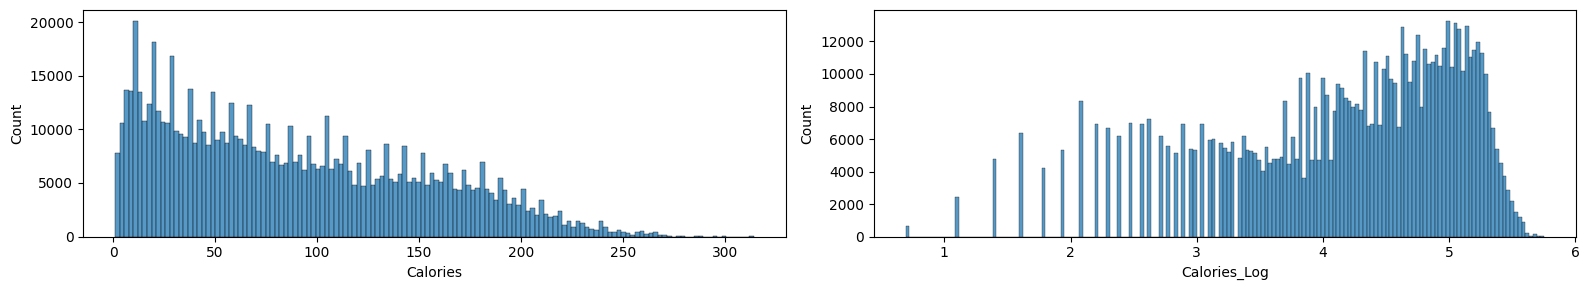

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train, x = 'Calories', ax = axes[0])
sns.histplot(df_train, x = 'Calories_Log', ax = axes[1])
plt.tight_layout()
plt.show()

- Calories는 좌측으로 치우친 분포를 하고 있습니다.

- Calories_log는 4개 ~ 4개의 봉우리가 있습니다. 봉우리에 관련된 요인을 찾는 것이 도움이 될 수 있으리라 생각됩니다. 

## Calories vs Calories_Log

- LGBMRegressor 심플하게 만들고 Shuffle Split Train size 0.8로 잡아 1회 검증을 통해 결과의 차이를 비교합니다.

In [72]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories'], scoring = 'neg_root_mean_squared_log_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.32884884]),
 'score_time': array([0.65864682]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06283713]),
 'train_score': array([-0.06006336])}

In [86]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 120), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([0.66256213]),
 'score_time': array([0.13081861]),
 'estimator': [LGBMRegressor(n_estimators=120, verbose=0)],
 'test_score': array([-0.06239613]),
 'train_score': array([-0.06081547])}

In [87]:
X = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'] 
result = cross_validate(
    lgb.LGBMRegressor(verbose = 0, n_estimators = 700), df_train[X], df_train['Calories_Log'], scoring = 'neg_root_mean_squared_error', 
    cv = ShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 1234), params = {'categorical_feature': X_cat},
    return_train_score = True, return_estimator = True
)
result

{'fit_time': array([2.2828002]),
 'score_time': array([0.66662002]),
 'estimator': [LGBMRegressor(n_estimators=700, verbose=0)],
 'test_score': array([-0.06091758]),
 'train_score': array([-0.0560343])}

- 결론: Calories_Log로 모델을 만들 때, 성능이 좋습니다. Calories를 Target으로 했을 경우, n_estimators 가  700보다 크면 과적합이 발생하기 시작한 반면,
Calories_Log로 할 경우에는 n_estimators 가 700 이후에도 test_score 가 떨어지지 않았고 teest의 성능도 Calories를 사용했을 때 보다 때 보다 좋음을 확인할 수 있었습니다.
- Calories_Log 만을 사용하여 모델을 만듭니다.


# 입력 변수 분석

In [28]:
df_train['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

In [31]:
X_num = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
df_train[X_num].describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697647,75.145676,15.421015,95.484009,40.036243
std,15.175049,12.824495,13.982703,8.354095,9.449845,0.779875
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.099998
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.599998
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.299999
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700001
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000


In [41]:
(df_train['Age'] - df_train['Age'].astype('int')).value_counts()

Age
0    750000
Name: count, dtype: int64

In [42]:
(df_test['Age'] - df_test['Age'].astype('int')).value_counts()

Age
0    250000
Name: count, dtype: int64

In [35]:
(df_train['Height'] - df_train['Height'].astype('int')).value_counts()

Height
0.000000    749999
0.100006         1
Name: count, dtype: int64

In [36]:
(df_test['Height'] - df_test['Height'].astype('int')).value_counts()

Height
0.0    250000
Name: count, dtype: int64

In [37]:
(df_train['Weight'] - df_train['Weight'].astype('int')).value_counts()

Weight
0.0    750000
Name: count, dtype: int64

In [38]:
(df_test['Weight'] - df_test['Weight'].astype('int')).value_counts()

Weight
0.0    250000
Name: count, dtype: int64

In [39]:
(df_train['Duration'] - df_train['Duration'].astype('int')).value_counts()

Duration
0.0    750000
Name: count, dtype: int64

In [40]:
(df_test['Duration'] - df_test['Duration'].astype('int')).value_counts()

Duration
0.0    250000
Name: count, dtype: int64

- Age, 	Height,	Weight, Duration, Heart_Rate 는 정수라고 할 수 있습니다.

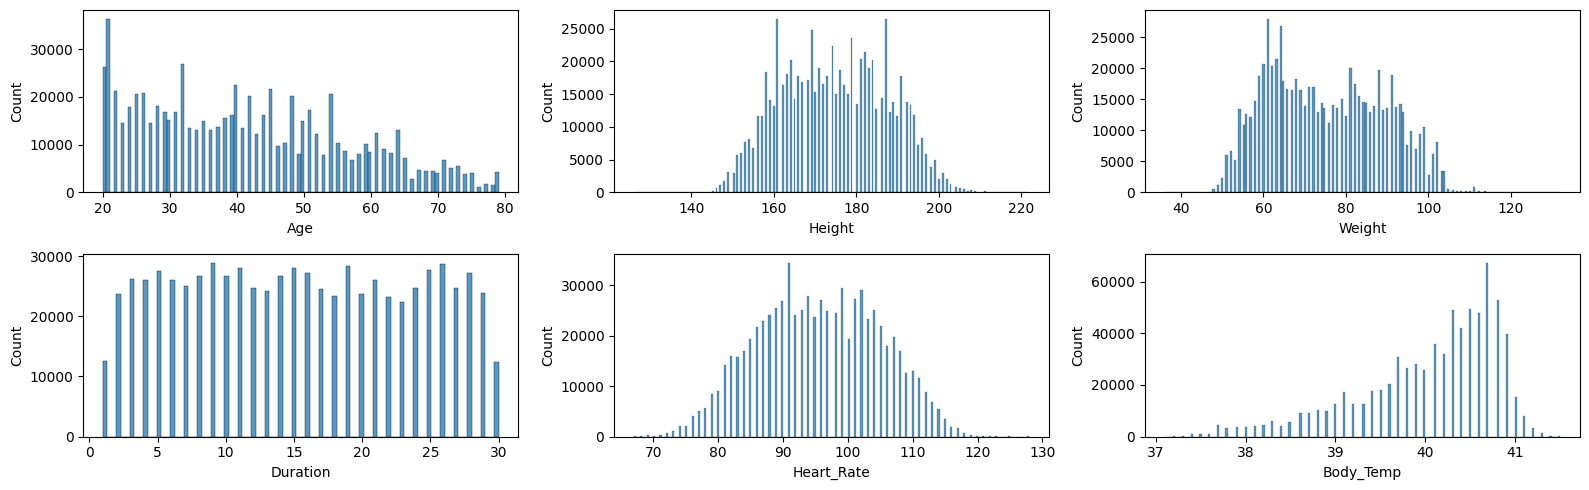

In [30]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
axes = axes.flatten()
for i, ax in zip(X_num, axes): 
    sns.histplot(df_train, x = i, ax = ax)
plt.tight_layout()
plt.show()

- Height, Weight, Heart_Rate 에 이상치로 생각 되는 것이 보입니다.  성능과의 영향도를 살펴봅니다 .

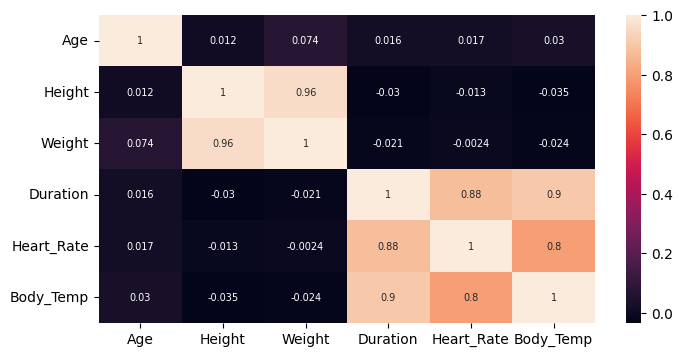

In [44]:
plt.figure(figsize = (8, 4))
sns.heatmap(
    df_train[X_num].corr(), annot = True, annot_kws = {'size' : 7}
)
plt.show()

- Height, Weight는 상관도가 0.96으로 강한 상관도 가 있고, 그 외 변수와 상관도가 떨아집니다. 

- Duration, Heart_Rate, Body_Temp는 강한 상관도 가 있습니다.

In [50]:
df_train.groupby('Sex')[X_num].agg(list).apply(
    lambda x: kruskal(*x).pvalue, axis = 0
)

Age           1.439142e-35
Height        0.000000e+00
Weight        0.000000e+00
Duration      1.339694e-17
Heart_Rate    1.544743e-06
Body_Temp     1.190521e-15
dtype: float64

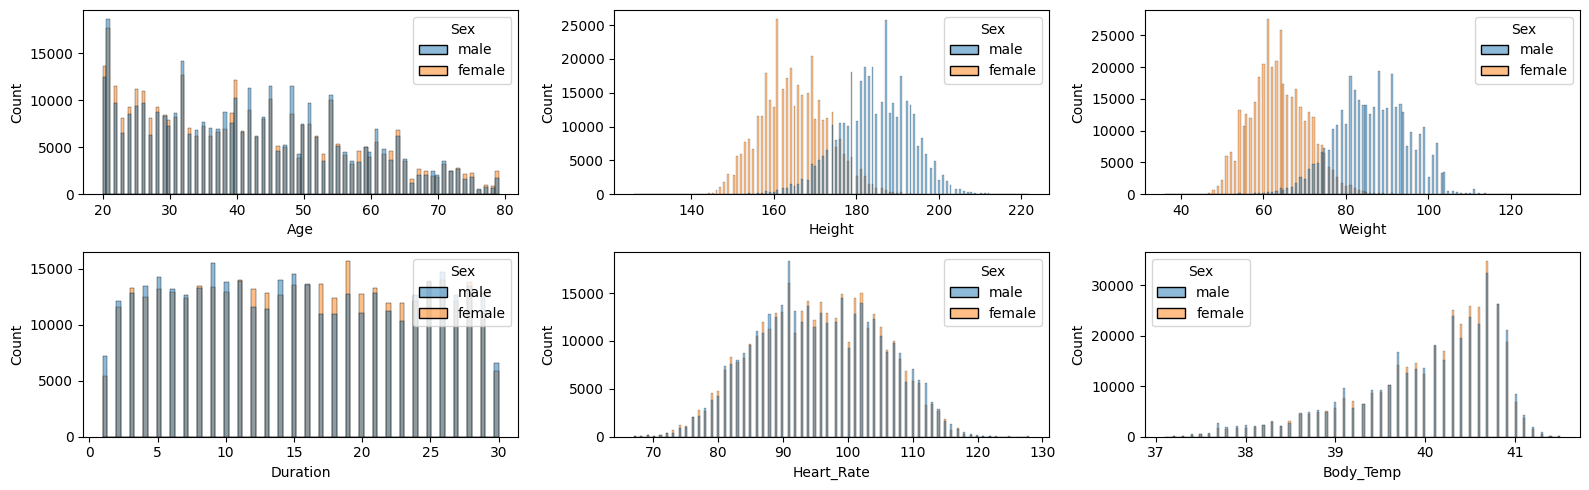

In [51]:
fig, axes = plt.subplots(2, 3, figsize = (16, 5))
axes = axes.flatten()
for i, ax in zip(X_num, axes): 
    sns.histplot(df_train, x = i, ax = ax, hue = 'Sex')
plt.tight_layout()
plt.show()

- Height, Weight는 Sex와 강한 상관도를 지니고 있습니다.

- Age, Duration, Heart_rate, Body_Temp 는 약한 상관도가 있습니다.

In [76]:
df_train[['Sex'] + X_num].value_counts().value_counts()

count
1     735018
2       6627
3        396
4         69
5         34
6          8
7          4
10         1
8          1
Name: count, dtype: int64

- 동일한 입력값이 관측이 되었습니다. target의 분산을 뽑아, 노이즈가 어느 정도 일지 측정해봅니다.

In [82]:
df_stat = df_train.groupby(['Sex'] + X_num).filter(lambda x: len(x) >= 5)\
    .groupby(['Sex'] + X_num, observed = True)['Calories_Log'].agg(['mean', 'std'])
df_stat

mean       std
Sex    Age Height Weight Duration Heart_Rate Body_Temp                    
male   21  187.0  91.0   25.0     104.0      40.799999  4.933030  0.003229
           193.0  99.0   21.0     102.0      40.700001  4.714847  0.013688
       32  187.0  92.0   15.0     102.0      40.299999  4.470400  0.015512
                         18.0     96.0       40.299999  4.458179  0.009386
           193.0  99.0   19.0     100.0      40.700001  4.670899  0.012133
       40  191.0  88.0   14.0     93.0       40.299999  4.174387  0.000000
       48  187.0  88.0   10.0     95.0       40.000000  3.973891  0.020434
                         11.0     90.0       40.000000  3.967571  0.007200
                                             40.099998  3.962598  0.017203
                                  91.0       40.000000  3.973407  0.007631
                                             40.099998  3.970292  0.000000
                  90.0   11.0     90.0       40.000000  3.967420  0.020012
                                  91.0       40.000000  3.985042  0.023943
           191.0  91.0   15.0     93.0       40.299999  4.356253  0.033666
           193.0  98.0   5.0      88.0       39.099998  3.126604  0.019879
       51  196.0  102.0  2.0      81.0       38.299999  2.079442  0.000000
       54  184.0  88.0   5.0      84.0       39.099998  3.044523  0.000000
           192.0  91.0   2.0      81.0       38.299999  2.079442  0.000000
       64  199.0  102.0  1.0      83.0       37.700001  1.609438  0.000000
female 21  169.0  64.0   9.0      91.0       39.799999  3.673689  0.013867
       32  150.0  51.0   1.0      86.0       37.700001  1.609438  0.000000
           161.0  61.0   15.0     91.0       40.299999  4.242572  0.022048
       34  163.0  62.0   21.0     99.0       40.700001  4.744932  0.000000
       40  152.0  51.0   25.0     109.0      40.700001  5.135798  0.000000
           161.0  61.0   13.0     99.0       40.299999  4.292696  0.010300
                         14.0     91.0       40.400002  4.209631  0.007650
                                  95.0       40.299999  4.295828  0.015507
                         15.0     91.0       40.299999  4.271032  0.012598
                  64.0   12.0     95.0       40.099998  4.133534  0.008764
                                  96.0       40.099998  4.155589  0.020228
                         13.0     93.0       40.099998  4.164889  0.023745
       42  161.0  60.0   16.0     91.0       40.299999  4.351548  0.007068
                  64.0   15.0     93.0       40.299999  4.317488  0.000000
       45  161.0  61.0   27.0     110.0      40.900002  5.235347  0.008790
       48  158.0  60.0   11.0     87.0       40.000000  3.912023  0.000000
                                  91.0       40.000000  3.991873  0.021485
                  61.0   11.0     89.0       40.000000  3.955053  0.008519
                                  90.0       40.000000  3.977698  0.016858
                                  91.0       40.000000  3.985245  0.008359
           161.0  60.0   11.0     91.0       40.000000  3.981473  0.012994
                                             40.099998  4.003399  0.026959
                  61.0   11.0     91.0       40.000000  3.975582  0.014231
                                             40.099998  3.977769  0.010238
                         13.0     99.0       40.299999  4.320137  0.005923
                         15.0     93.0       40.299999  4.326290  0.010758
                  64.0   11.0     91.0       40.000000  3.974030  0.008359
                  65.0   11.0     91.0       40.000000  4.003664  0.008206
       54  161.0  61.0   14.0     95.0       40.299999  4.345418  0.004562

In [83]:
df_stat['std'].mean()

0.010665245

- 약 0.01 입니다.

# ML Configuration

- Org 데이터를 포함할 지를 살펴봅니다.

- Calories_Log를 사용하고, 이를 검증하기 위해서 설정했던, LGBMClassifer n_estimators = 700 으로 성능을 비교해봅니다.

In [61]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(4, random_state = 123, shuffle = True)
X_cat = ['Sex']
X_num = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
X_all = X_cat + X_num
target = 'Calories_Log'
result = cross_val_score(
    lgb.LGBMRegressor(n_estimators = 700), df_train[X_all], df_train[target], cv = kf, 
    params = {'categorical_feature': ['Sex']}, scoring = 'neg_root_mean_squared_error')
result

array([-0.06028604, -0.0613832 , -0.05933871, -0.06113434])

In [68]:
df_org = df_org.rename(columns = {'Gender': 'Sex'}).assign(
    Calories_Log = lambda x: np.log(x['Calories'])
)

In [69]:
from sklearn.metrics import root_mean_squared_error
reg_lgb = lgb.LGBMRegressor(n_estimators = 700)
rmse_oof = list()
for train_idx, valid_idx in kf.split(df_train[X_all], df_train):
    df_cv_train = pd.concat([
        df_train.iloc[train_idx], 
        df_org
    ])
    reg_lgb.fit(df_cv_train[X_all], df_cv_train[target], categorical_feature = ['Sex'])
    df_valid = df_train.iloc[valid_idx]
    rmse_oof.append(
        root_mean_squared_error(df_valid[target], reg_lgb.predict(df_valid[X_all]))
    )
rmse_oof

[0.060461383548048954,
 0.06140324584199924,
 0.059401099122018415,
 0.06121519282515802]

- 성능에는 큰 개선 효과는 보이지 않아 포함시키지 않습니다.

In [85]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit

kf = KFold(4, random_state = 123, shuffle = True)
ss = ShuffleSplit(1, random_state = 123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index = df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target], prds),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'y': target,
}

# 상관도 분석

In [ ]:
kruskal(df_train.groupby('Sex')['Calories_Log].agg(list)